In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/output.zip -d /content/
!unzip /content/drive/MyDrive/EfficientNet.zip -d /content/


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/output/class_3/20211001_20211001_121436_738_png_crop_0.jpg  
  inflating: /content/__MACOSX/output/class_3/._20211001_20211001_121436_738_png_crop_0.jpg  
  inflating: /content/output/class_3/20210910_105244_-_-_1084_w0009_png_crop_0.jpg  
  inflating: /content/__MACOSX/output/class_3/._20210910_105244_-_-_1084_w0009_png_crop_0.jpg  
  inflating: /content/output/class_3/20210911_133457_-_-_376_w0031_png_crop_0.jpg  
  inflating: /content/__MACOSX/output/class_3/._20210911_133457_-_-_376_w0031_png_crop_0.jpg  
  inflating: /content/output/class_3/20210909_123421_-_-_1807_w0014_png_crop_0.jpg  
  inflating: /content/__MACOSX/output/class_3/._20210909_123421_-_-_1807_w0014_png_crop_0.jpg  
  inflating: /content/output/class_3/20210919_121236_-_-_1616_w0007_png_crop_0.jpg  
  inflating: /content/__MACOSX/output/class_3/._20210919_121236_-_-_1616_w0007_png_crop_0.jpg  
  inflating: /content/output/class_3/20210918_20210918_131745_320

In [ ]:
!git clone https://github.com/lukemelas/EfficientNet-PyTorch

Cloning into 'EfficientNet-PyTorch'...
remote: Enumerating objects: 665, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 665 (delta 26), reused 58 (delta 23), pack-reused 595 (from 1)
Receiving objects: 100% (665/665), 1.14 MiB | 15.00 MiB/s, done.
Resolving deltas: 100% (341/341), done.


In [ ]:
%cd /content/EfficientNet-PyTorch

/content/EfficientNet-PyTorch


In [ ]:
!pip install -e .

Obtaining file:///content/EfficientNet-PyTorch
  Preparing metadata (setup.py) ... done
  Running setup.py develop for efficientnet_pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b3')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 102MB/s] 


Loaded pretrained weights for efficientnet-b3


In [ ]:
## 학습 코드
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b3'  # b3

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=15)

300
Loaded pretrained weights for efficientnet-b3


In [ ]:
## 데이타 로드!!
batch_size  = 16
random_seed = 100
random.seed(random_seed)
torch.manual_seed(random_seed)

## make dataset
from torchvision import transforms, datasets
data_path = '/content/output'  # class 별 폴더로 나누어진걸 확 가져와서 라벨도 달아준다
president_dataset = datasets.ImageFolder(
                                data_path,
                                transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                ]))
## data split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
train_idx, tmp_idx = train_test_split(list(range(len(president_dataset))), test_size=0.2, random_state=random_seed)
datasets = {}
datasets['train'] = Subset(president_dataset, train_idx)
tmp_dataset       = Subset(president_dataset, tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5, random_state=random_seed)
datasets['valid'] = Subset(tmp_dataset, val_idx)
datasets['test']  = Subset(tmp_dataset, test_idx)

## data loader 선언
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
dataloaders['test']  = torch.utils.data.DataLoader(datasets['test'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  tvt : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 16,  tvt : 148 / 19 / 19


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 52384 (\N{HANGUL SYLLABLE CEOL}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 50676 (\N{HANGUL SYLLABLE YEOL}) missing from current font.
  plt.pause(0.001)  # 

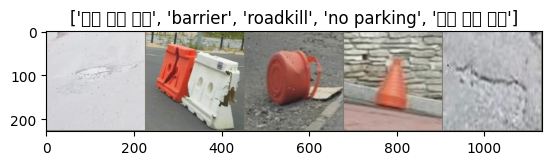

<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 49444 (\N{HANGUL SYLLABLE SEOL}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 48520 (\N{HANGUL SYLLABLE BUL}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.pause(0.001)  #

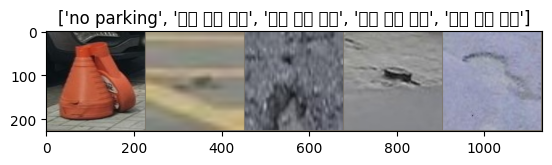

<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from c

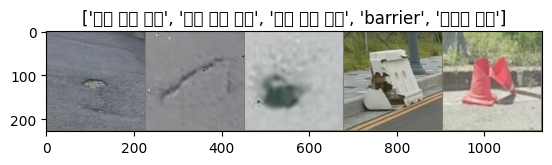

In [ ]:
## 데이타 체크
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num_show_img = 5

class_names = {
    "0": "barrier",      #!
    "1": "no parking",   #!
    "2": "roadkill",  # !
    "3": "도로 요철 균열",  #!
    "4": "표지판 파손",   #!
    "5": "배수 시설 불량",   # !
    "6": "가드레일", # !
    "7:": "pe drum", #!
    "8": "porthole", #!
    "9": "rubbercone", #!
    "10": "tubular", #!
    "11": "낙석", #!
    "12": "노면 균열", #!
    "13": "중앙 분리대", # !
    "14": "보도블럭 파손" #!
}

# train check
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# valid check
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# test check
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()

            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'president_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(),
                         lr = 0.01,
                         momentum=0.9,
                         weight_decay=1e-4)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

In [ ]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=60)

Epoch 0/59
----------
train Loss: 0.38 Acc: 90.1
valid Loss: 0.12 Acc: 95.9
==> best model saved - 0 / 95.9
Epoch 1/59
----------
train Loss: 0.07 Acc: 97.8
valid Loss: 0.13 Acc: 96.3
==> best model saved - 1 / 96.3
Epoch 2/59
----------
train Loss: 0.06 Acc: 98.3
valid Loss: 0.10 Acc: 96.6
==> best model saved - 2 / 96.6
Epoch 3/59
----------
train Loss: 0.03 Acc: 99.3
valid Loss: 0.08 Acc: 97.3
==> best model saved - 3 / 97.3
Epoch 4/59
----------
train Loss: 0.02 Acc: 99.4
valid Loss: 0.06 Acc: 98.0
==> best model saved - 4 / 98.0
Epoch 5/59
----------
train Loss: 0.02 Acc: 99.4
valid Loss: 0.08 Acc: 98.3
==> best model saved - 5 / 98.3
Epoch 6/59
----------
train Loss: 0.01 Acc: 99.8
valid Loss: 0.06 Acc: 98.6
==> best model saved - 6 / 98.6
Epoch 7/59
----------
train Loss: 0.01 Acc: 99.9
valid Loss: 0.09 Acc: 98.6
Epoch 8/59
----------
train Loss: 0.01 Acc: 99.8
valid Loss: 0.11 Acc: 98.6
Epoch 9/59
----------
train Loss: 0.00 Acc: 100.0
valid Loss: 0.07 Acc: 99.0
==> best model 

best model : 33 - 99 / 0.1


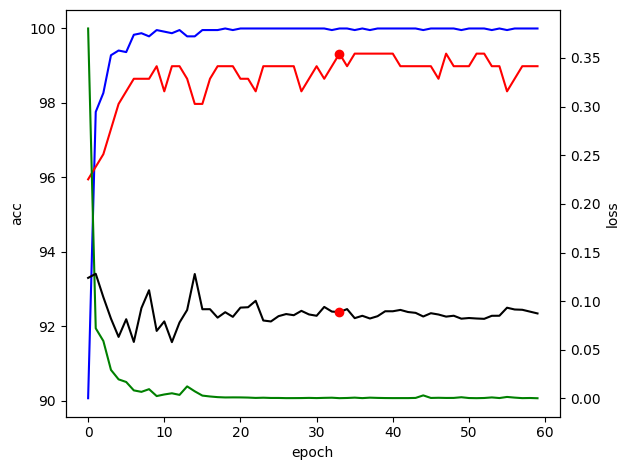

In [ ]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

In [ ]:
dataloaders['test']  = torch.utils.data.DataLoader(datasets['test'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)

test done : loss/acc : 0.04 / 99.7


<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 52384 (\N{HANGUL SYLLABLE CEOL}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 50676 (\N{HANGUL SYLLABLE YEOL}) missing from current font.
  plt.pause(0.001)  # 

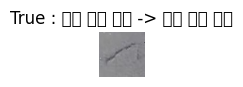

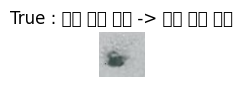

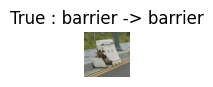

<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated
<ipython-input-9-f1c3480f6346>:13: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  plt.pause(0.001)  # pause a bit so that plots are updated


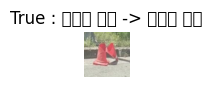

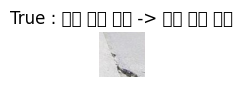

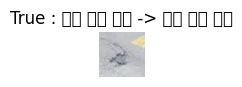

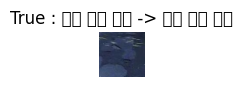

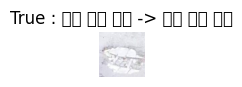

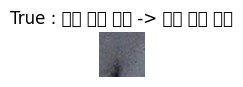

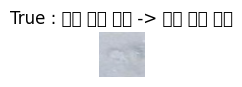

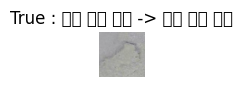

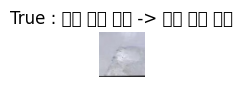

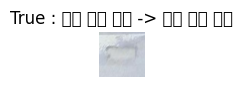

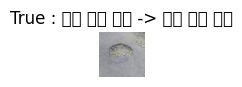

ValueError: num must be an integer with 1 <= num <= 14, not 15

<Figure size 640x480 with 0 Axes>

In [ ]:
def test_and_visualize_model(model, phase = 'test', num_images=15):
    # phase = 'train', 'valid', 'test'

    was_training = model.training
    model.eval()
    fig = plt.figure()

    running_loss, running_corrects, num_cnt = 0.0, 0, 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)  # batch의 평균 loss 출력

            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)
            num_cnt += inputs.size(0)  # batch size

    #         if i == 2: break

        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt
        print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

    # 예시 그림 plot
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # 예시 그림 plot
            for j in range(1, num_images+1):
                ax = plt.subplot(num_images//2, 2, j)
                ax.axis('off')
                ax.set_title('%s : %s -> %s'%(
                    'True' if class_names[str(labels[j].cpu().numpy())]==class_names[str(preds[j].cpu().numpy())] else 'False',
                    class_names[str(labels[j].cpu().numpy())], class_names[str(preds[j].cpu().numpy())]))
                imshow(inputs.cpu().data[j])
            if i == 0 : break


    model.train(mode=was_training);  # 다시 train모드로

## TEST!
test_and_visualize_model(model, phase = 'test')